In [1]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor, sam_model_registry)
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *
from kmeans_pytorch import kmeans

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Hyper-parameters

In [2]:
FEATURE_DIM = 32

DATA_ROOT = './data/dynerf/cut_roasted_beef'
# the model path, same to the --model_path in the training, after train_scene.py this folder will be created but named randomly
MODEL_PATH = './output/dynerf/cut_roasted_beef'
GAUSSIAN_ITERATION = 14000

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# SAM_ARCH = 'vit_h'
# SAM_CKPT_PATH = '/data/sxj/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = "./arguments/dynerf/cut_roasted_beef.py")
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.object_masks = True
dataset.need_gt_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode)

Looking for config file in ./output/dynerf/cut_roasted_beef/feature_cfg_args
Config file found at: ./output/dynerf/cut_roasted_beef/feature_cfg_args
mode:  feature
Loading trained model at iteration 14000
meta data loaded, total image:5700
meta data loaded, total image:300
load finished. Train Dataset Length: 5700


100%|██████████| 5700/5700 [00:00<00:00, 181106.70it/s]
300it [00:00, 70551.79it/s]


origin points, 37243
after points, 37243
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [21.35526085 15.11961842 50.36367798] [-25.87877274 -14.45879078   5.38203239]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 21.3553,  15.1196,  50.3637],
        [-25.8788, -14.4588,   5.3820]])
loading model from exists./output/dynerf/cut_roasted_beef/point_cloud/iteration_14000


## Begin Segmentation

In [4]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

# video_cameras = [i for i in scene.getVideoCameras()]
# train_cameras = [i for i in scene.getTrainCameras()]
video_cameras = scene.getVideoCameras()
train_cameras = scene.getTrainCameras()
cam_type = scene.dataset_type
print("There are",len(train_cameras),"views in the dataset.")

There are 5700 views in the dataset.


In [5]:
def plot(img_list, axis=False):
    l = len(img_list)
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(img_list):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if axis == False:
            plt.axis('off')
    plt.show()

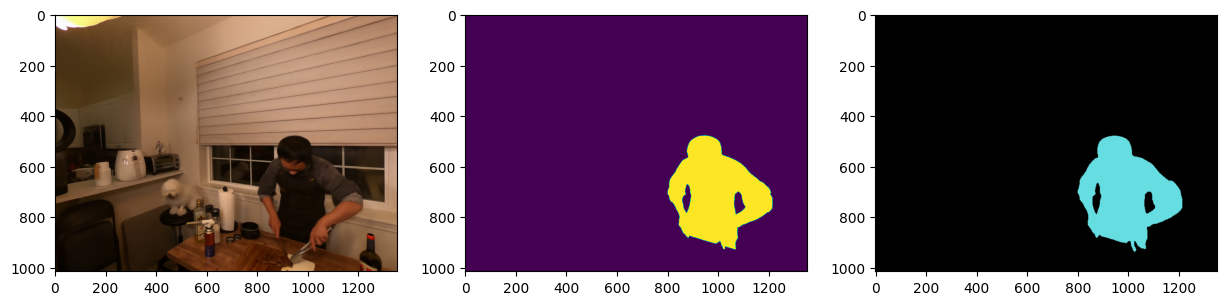

In [6]:
ref_img_camera_id = 0
mask_img_camera_id = 0
ref_view = train_cameras[ref_img_camera_id]

with torch.no_grad():
    rendering = render(ref_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    # img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    objects = ref_view.objects
    
    logits = render_contrastive_feature(ref_view, gaussians, pipeline, bg_feature)["render"]
    prob = torch.sigmoid(logits)
    pred_mask = (prob > 0.5).int().squeeze().cpu().numpy()
    
    plot([img, pred_mask, objects], axis=True)

tensor(3827, device='cuda:0')


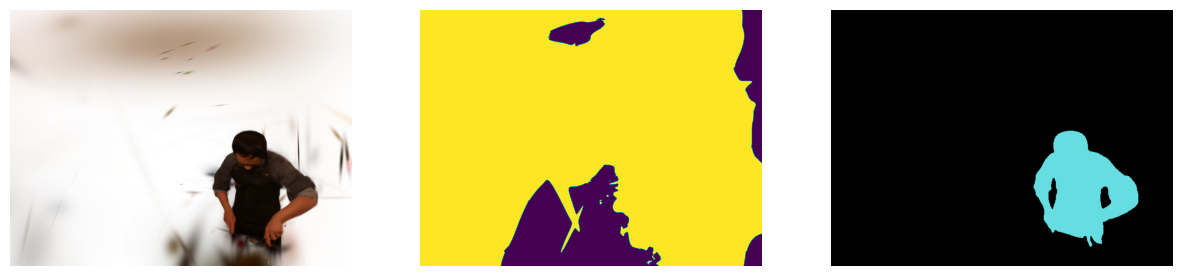

In [7]:
gt_mask = objects
with torch.no_grad():
    means3D = gaussians.get_xyz
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    
    logits3d = gaussians._mlp(means3D, ts)
    prob = torch.sigmoid(logits3d)
    mask3d = (prob > 0.4).squeeze()
    # mask3d = mask.any(dim=0).squeeze()
    print(mask3d.count_nonzero())
    
    # plot
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=mask3d.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    plot([target_img_seg, rendered_mask, gt_mask.detach().cpu()])

In [9]:
from utils.segment_utils import *

render_images = []
with torch.no_grad():
    for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
        if idx == 0: time1 = time.time()
        
        means3D = gaussians.get_xyz
        ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
        
        logits3d = gaussians._mlp(means3D, ts)
        prob = torch.sigmoid(logits3d)
        mask3d = (prob > 0.5).squeeze()
        
        rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
        render_images.append(to8b(rendering.detach()).transpose(1,2,0))
        
time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(GAUSSIAN_ITERATION), 'video_seg_man.mp4'), render_images, fps=30)

Rendering progress:   0%|          | 0/300 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 300/300 [00:11<00:00, 26.12it/s]


FPS: 26.137994286368563


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1352, 1014) to (1360, 1024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6ce3b40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [53]:
test_views = [i for i in scene.getTestCameras()]

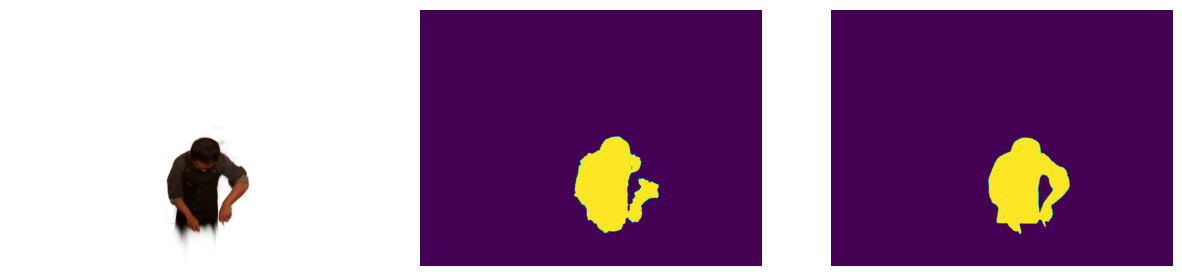

In [77]:
target_view = test_views[50]
with torch.no_grad():
    diff = torch.abs(gaussians._time_map - target_view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]

    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    plot([target_img_seg, rendered_mask, target_view.gt_mask.squeeze().int()])

In [78]:
miou = 0.
macc = 0.
for idx, view in enumerate(tqdm(test_views)):
     #! render
     diff = torch.abs(gaussians._time_map - view.time)
     index = torch.argmin(diff)
     mask = gaussians._mask_table[index]
     
     rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
     rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
     # rendered_mask = rendered_mask.int()

     gt_mask = view.gt_mask.bool()
     
     #! metrics
     iou = (rendered_mask & gt_mask).sum() / (rendered_mask | gt_mask).sum()
     # iou += ((~rendered_mask) & (~gt_mask)).sum() / ((~rendered_mask) | (~gt_mask)).sum()
     # iou /= 2
     acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
     miou += iou
     macc += acc
     # print(miou)
     # break
     
     torch.cuda.empty_cache()

miou /= len(test_views)
macc /= len(test_views)
print("mIoU: %.4f" % (miou * 100))
print("mAcc: %.4f" % (macc * 100))

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:13<00:00, 21.86it/s]

mIoU: 86.1911
mAcc: 99.1832


: 